In [7]:
import axs
import numpy as np

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as pyspark_types
import numpy as np

from functools import partial

import tqdm

import dipper

In [8]:
%matplotlib notebook

# Setup spark

In [9]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            #.config('spark.master', "local[6]")
            .config("spark.master", "local[32]") # yolo mode
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/kyboone/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

# Load ZTF data

In [10]:
ztf = catalog.load('ztf_oct19')

## Load the saved axs table

In [15]:
wtf = catalog.load('wtf_full_oct19_4')

In [12]:
wtf.count()

159994

In [13]:
# Recalculate the scores
rescored_wtf = (
    wtf.select(
        '*',
        dipper.detect_dippers_udf(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r']
        ).alias('rescored_dipper'),
    )
)

In [17]:
wtf.where(sparkfunc.col("dipper.significance") > 20.).count()

7522

In [18]:
ztf.count()

1256397643

In [14]:
%%time

# Get the best entries
res = rescored_wtf.sort(rescored_wtf['rescored_dipper.intmag'].desc()).head(1000)

CPU times: user 312 ms, sys: 140 ms, total: 452 ms
Wall time: 25.7 s


In [22]:
%matplotlib inline

from ipywidgets import interact, IntSlider

def interact_lightcurve(idx, zoom=False):
    show_lightcurve(res[idx], zoom=zoom)

interact(interact_lightcurve, idx=IntSlider(0, 0, len(res) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=999), Checkbox(value=False, description='zoom'), Output()), _dom_classes=('widget-interact',))

<function __main__.interact_lightcurve>

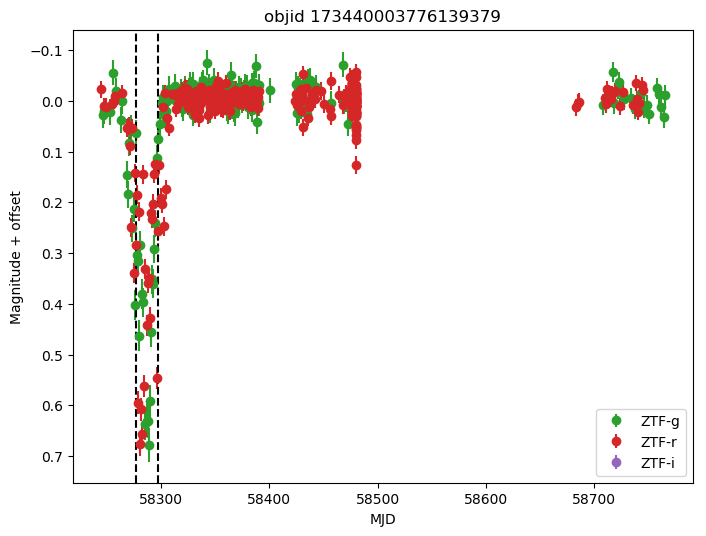

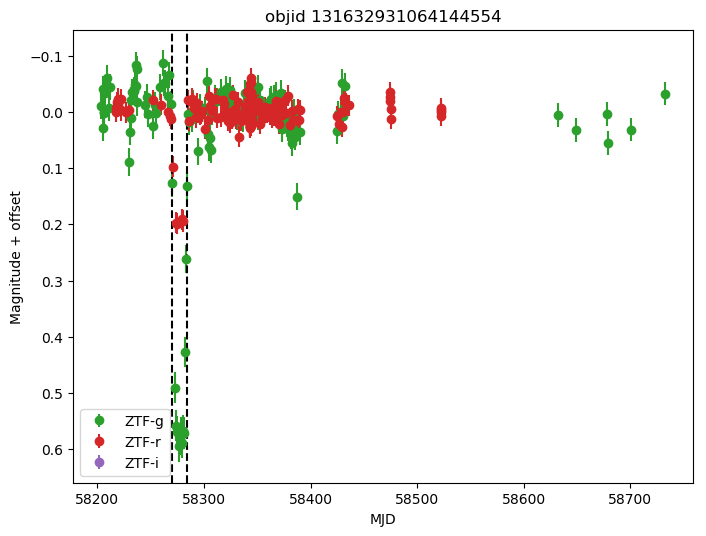

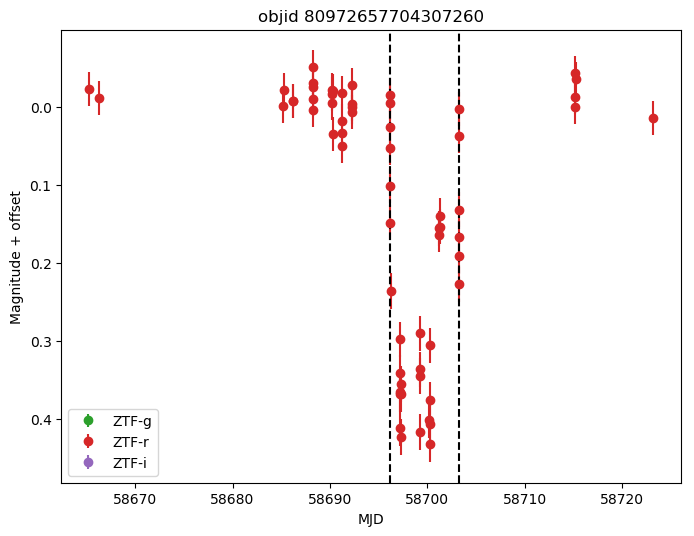

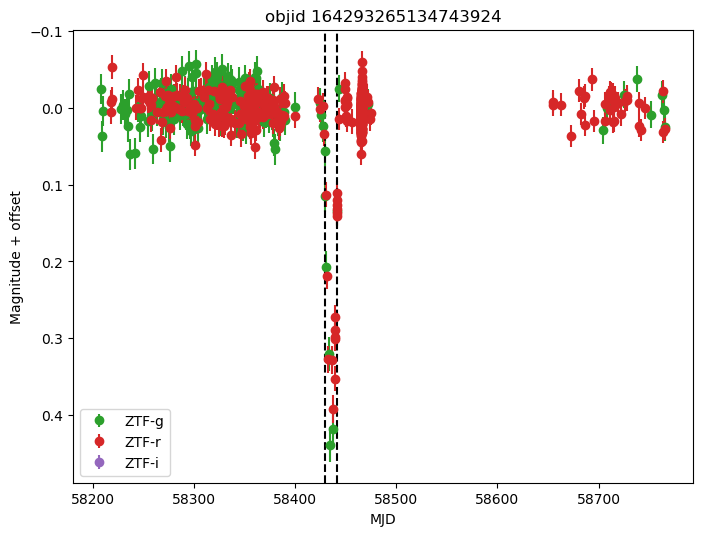

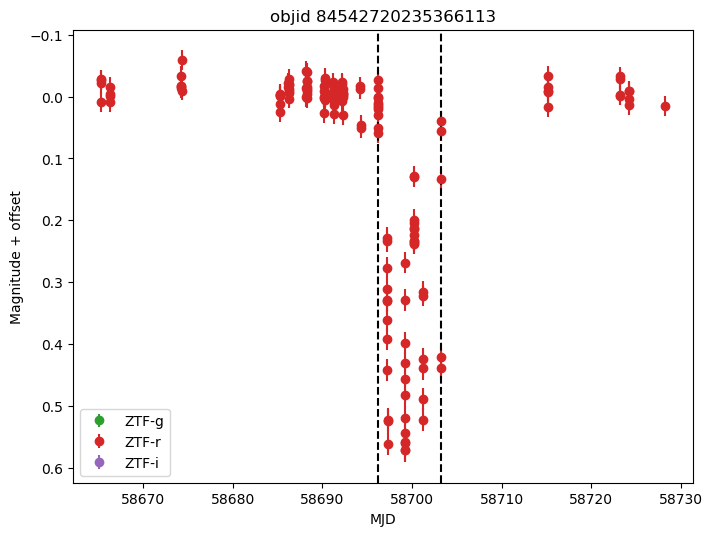

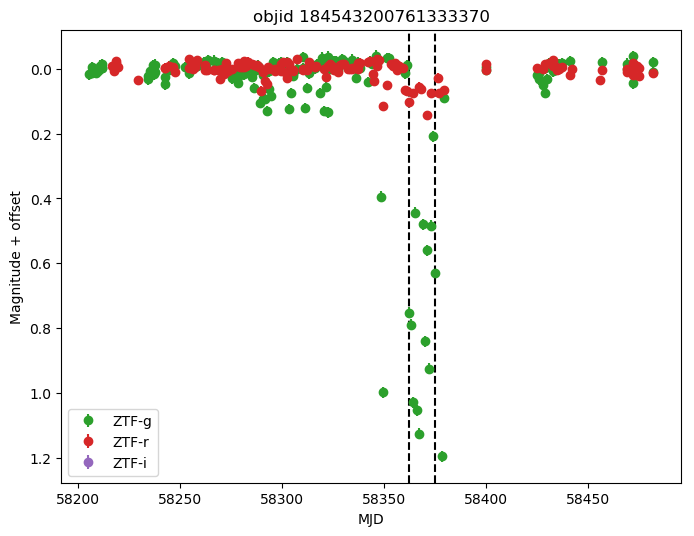

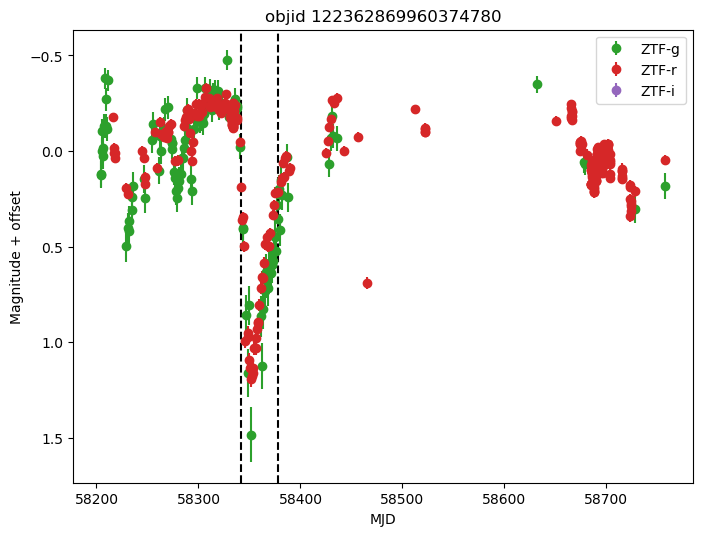

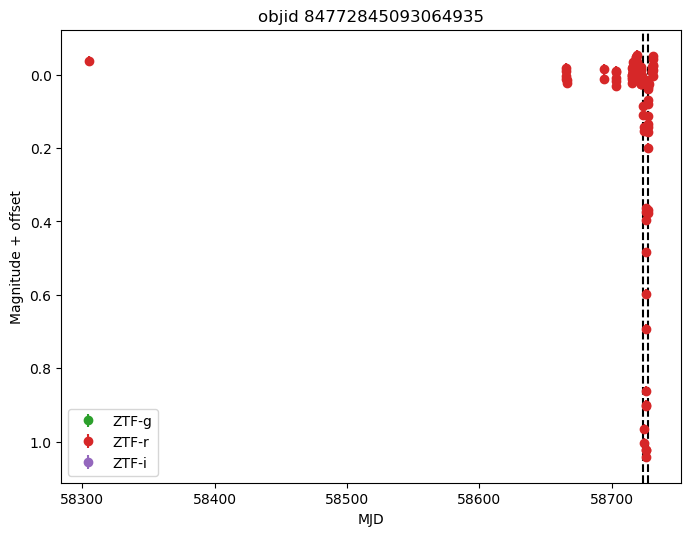

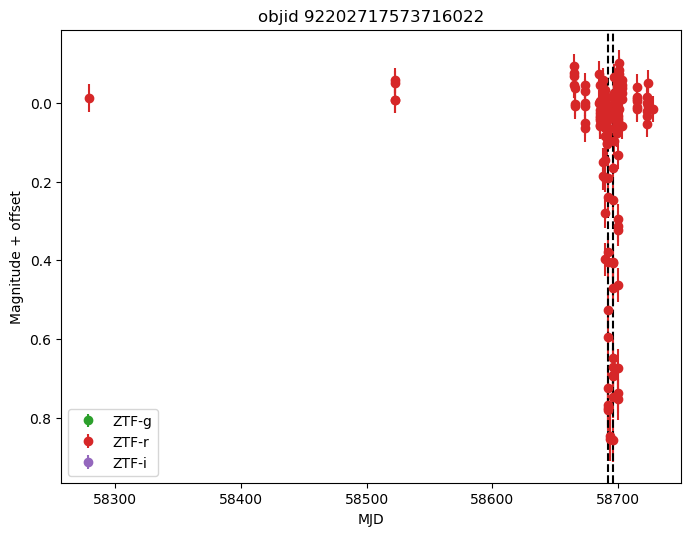

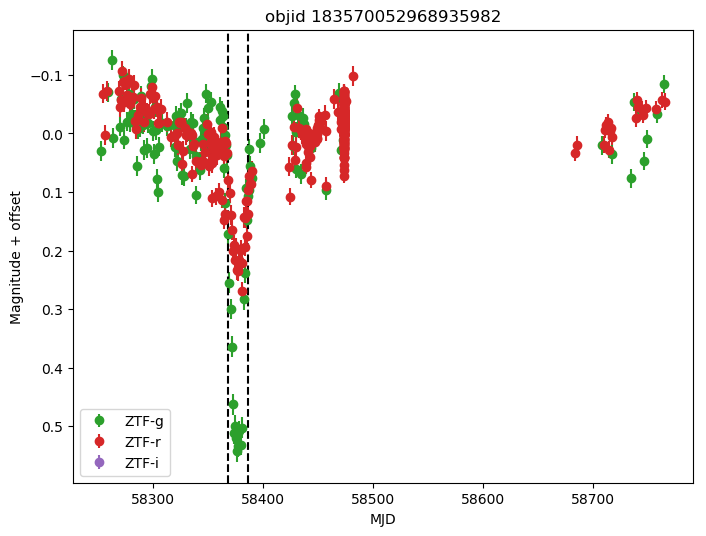

In [67]:
for idx in range(10):
    show_lightcurve(res[idx], verbose=False)

## Label how the dip detection works

In [23]:
detect_dippers_row(res[0])

{'complexity': 1.901047088406095,
 'end_mjd': 58378.1699306,
 'intmag': 27.16299534918034,
 'nobs': 56,
 'num_dips': 21,
 'significance': 150.39786185513984,
 'start_mjd': 58341.3244329}

In [ ]:
band_colors = {
    'g': 'tab:green',
    'r': 'tab:red',
    'i': 'tab:purple'
}

def label_dip(row):
    plt.figure(figsize=(8, 6), dpi=100)

    for band in ['g', 'r', 'i']:
        mjd, mag, magerr = parse_observations(
            row[f'mjd_{band}'],
            row[f'mag_{band}'],
            row[f'magerr_{band}'],
            row[f'xpos_{band}'],
            row[f'ypos_{band}'],
            row[f'catflags_{band}'],
        )
        
        plt.errorbar(mjd, mag, magerr, fmt='o', c=band_colors[band], label=f'ZTF-{band}')
        
    

    plt.xlabel('MJD')
    if parsed:
        plt.ylabel('Magnitude + offset')
    else:
        plt.ylabel('Magnitude')
    plt.legend()
    plt.title('objid %d' % row['objid'])
    plt.gca().invert_yaxis()

# Joining

In [12]:
gaia = catalog.load('gaia_dr2_1am_dup')

In [13]:
wtf_df = rescored_wtf.crossmatch(gaia.select('ra', 'dec', 'zone', 'dup', 'parallax', 'parallax_over_error', 'phot_g_mean_mag',
                                'bp_rp')).toPandas()

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


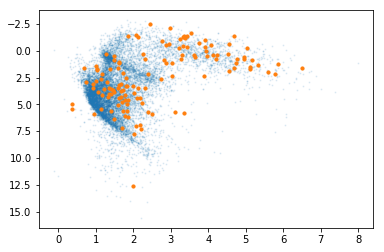

In [36]:
plt.figure()
abs_mag = wtf_df['phot_g_mean_mag'] - 5 * np.log10(1000 / wtf_df['parallax']) + 5

cut = (wtf_df['parallax_over_error'] > 5)
plt.scatter(wtf_df['bp_rp'][cut], abs_mag[cut], s=1, alpha=0.1)

cut = (wtf_df['parallax_over_error'] > 5) & (wtf_df['new_score'] > 2.5)
plt.scatter(wtf_df['bp_rp'][cut], abs_mag[cut], s=10)


plt.gca().invert_yaxis()

In [40]:
def print_links(row):
    print("http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%.6f%+.6f&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=" % (row['ra'], row['dec']))
    print("RA+Dec: %.6f%+.6f" % (row['ra'], row['dec']))
    print("RA:     %.6f" % row['ra'])
    print("Dec:    %.6f" % row['dec'])

def show_lightcurve(idx):
    row = wtf_df.iloc[idx]  
    #print_links(row)    
    plot_lightcurve(row)
    plt.title(idx)

    print("Score:  %.3f" % detect_dippers_row(row))

In [41]:
a = np.where(cut & (df['bp_rp'] > 0.5) & (df['bp_rp'] < 2) & (abs_mag < 1000) & (abs_mag > 5.))

Score:  2.566
Score:  2.795
Score:  2.650
Score:  2.909
Score:  2.530
Score:  2.687
Score:  2.845
Score:  2.584
Score:  2.648
Score:  3.264
Score:  3.082


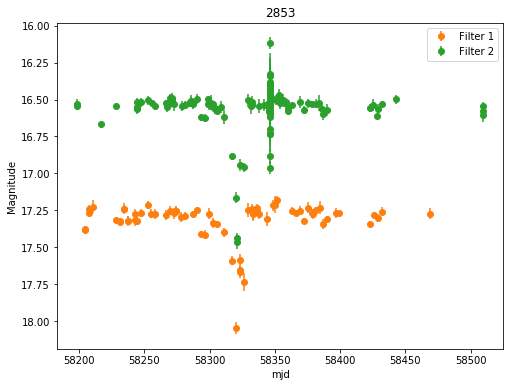

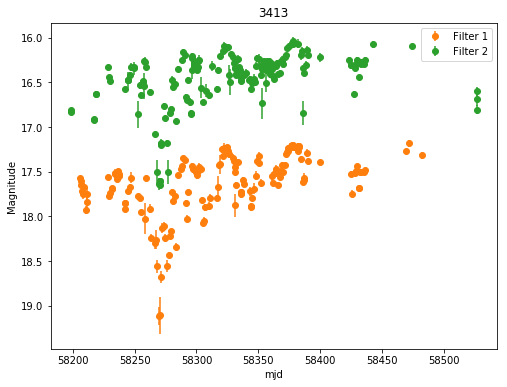

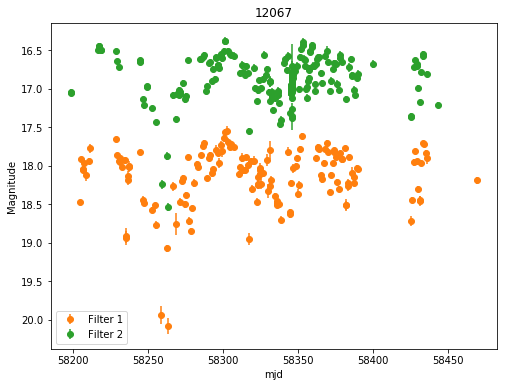

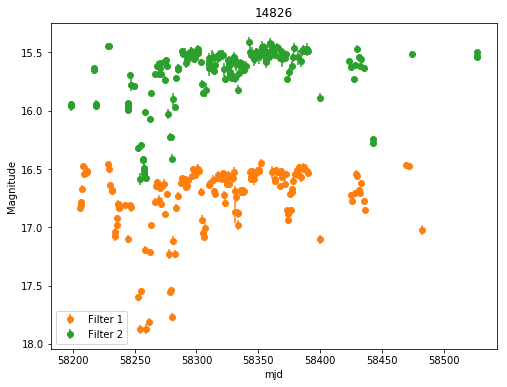

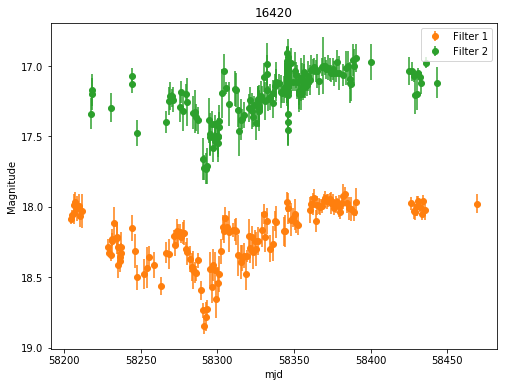

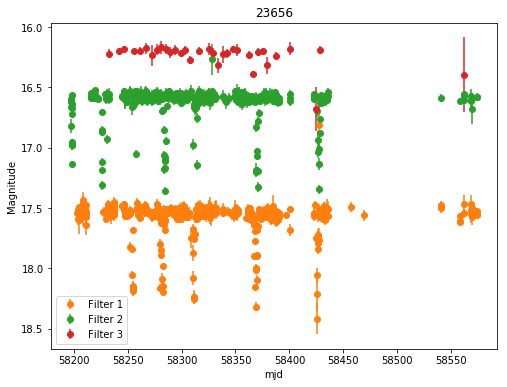

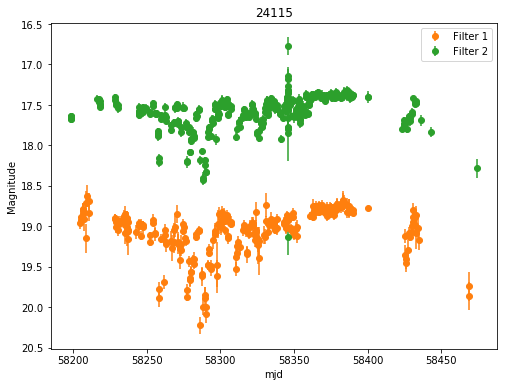

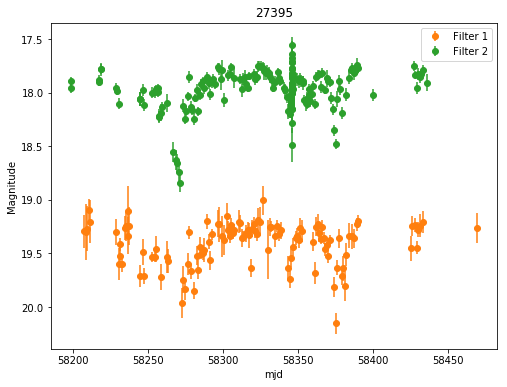

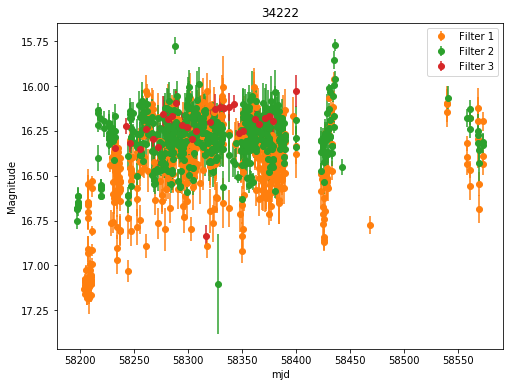

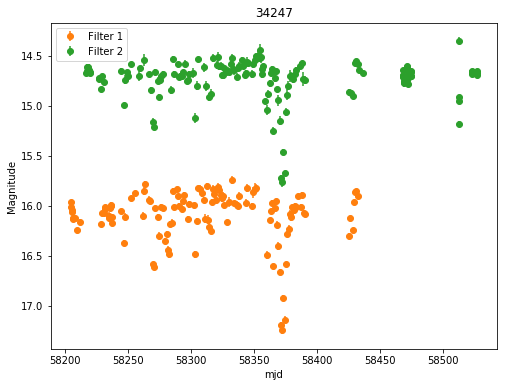

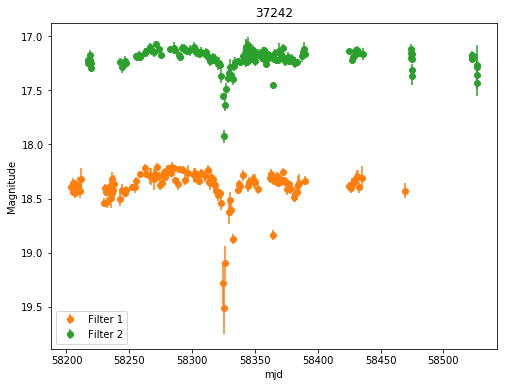

In [42]:
for i in a[0]:
    show_lightcurve(i)

# Run the spark query

## Run and save the query

In [ ]:
%%time

# Run on spark
res = (
    ztf
    .exclude_duplicates()
    #.region(ra1=295, ra2=296, dec1=20, dec2=21)
    .where(
        (sparkfunc.col("nobs_g") >= 10)
        | (sparkfunc.col("nobs_r") >= 10)
        | (sparkfunc.col("nobs_i") >= 10)
    )
    .select(
        '*',
        detect_dippers_udf(
            ztf['mjd_g'],
            ztf['mag_g'],
            ztf['magerr_g'],
            ztf['xpos_g'],
            ztf['ypos_g'],
            ztf['catflags_g'],
            ztf['mjd_r'],
            ztf['mag_r'],
            ztf['magerr_r'],
            ztf['xpos_r'],
            ztf['ypos_r'],
            ztf['catflags_r']
        ).alias('dipper'),
    )
    .where(
        (sparkfunc.col("dipper.significance") > 10.)
    )
    #.write.parquet('./query_test_23.parquet')
    .write.parquet('./query_full_4.parquet')
)

## Convert to an axs table

In [ ]:
wtf = spark_session.read.parquet('./query_full_4.parquet')

In [22]:
%matplotlib inline

from ipywidgets import interact, IntSlider

def interact_lightcurve(idx, zoom=False):
    show_lightcurve(res[idx], zoom=zoom)

interact(interact_lightcurve, idx=IntSlider(0, 0, len(res) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=999), Checkbox(value=False, description='zoom'), Output()), _dom_classes=('widget-interact',))

<function __main__.interact_lightcurve>

In [ ]:
catalog.save_axs_table(wtf, 'wtf_full_oct19_4', repartition=True)